In [1]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
from PIL import ImageFilter
import ast
import json
from glob import glob

In [2]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.1', True)

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [4]:
(128 * 8, 128 * 15), (128 * 4, 128*8)

((1024, 1920), (512, 1024))

In [5]:
path_root_folder = '/home/mvlab/Downloads/dataset/ena24/'
path_ena_label = path_root_folder + 'ena24.json'
path_ena_image = path_root_folder

os.path.isdir(path_root_folder), os.path.isfile(path_ena_label)

(True, True)

In [6]:
#padded_image_shape = (1024, 1920)
min_stride = 128
padded_image_shape = (128*4, 128*8)
anchor_k = 9
num_classes = 80#
num_classes_real = 30
max_data_m = 300000
is_no_human = False
use_size_down = True
use_zoom_up_data = False
use_ENA = False
level_start = 3
level_end = 8
l1 = 1e-8
activation = 'swish'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
#class_names = ['bg', 'pig', 'crow']
class_names_kor = ['배경', '모름', '돼지사체', '멧돼지사체', '돼지','멧돼지', '큰부리까마귀', '흰배지빠귀', '유리딱새', '동고비', 
               '박새', '호랑지빠귀', '검독수리', '너구리', '쥐', '다람쥐', '사람', 
                   'car' , '오소리', '개','고양이']
class_names = ['bg', 'unknown', 'pig_dead', 'boar_dead', 'pig', 'boar', 'crow', 'bird_white', 'bird_ddak', 'bird_dong', 
               'bird_bak', 'bird_tire', 'bird_eagle', 'racoon', 'rat', 'squrrel', 'human', 
               'car', 'opossum', 'dog','cat']

folder_pig = '/home/mvlab/Downloads/dataset/pig/'
path_weight = "retinanet/pig_EfficientDet-D2"

os.path.isdir(folder_pig)

True

In [7]:
categories_ENA = [
    {"name": "Bird","id": 0},
    {"name": "Eastern Gray Squirrel","id": 1    },
    {"name": "Eastern Chipmunk",      "id": 2    },
    {"name": "Woodchuck",      "id": 3    },
    {"name": "Wild Turkey",      "id": 4    },
    {"name": "White_Tailed_Deer",      "id": 5    },
    {"name": "Virginia Opossum",      "id": 6    },
    {"name": "Eastern Cottontail",      "id": 7    },
    {"name": "Human",      "id": 8    },
    {"name": "Vehicle",      "id": 9    },
    {"name": "Striped Skunk",      "id": 10    },
    {"name": "Red Fox",      "id": 11    },
    {"name": "Eastern Fox Squirrel",      "id": 12    },
    {"name": "Northern Raccoon",      "id": 13    },
    {"name": "Grey Fox",      "id": 14    },
    {"name": "Horse",      "id": 15    },
    {"name": "Dog",      "id": 16    },
    {"name": "American Crow",      "id": 17    },
    {"name": "Chicken",      "id": 18    },
    {"name": "Domestic Cat",      "id": 19    },
    {"name": "Coyote",      "id": 20    },
    {"name": "Bobcat",      "id": 21    },
    {"name": "American Black Bear",      "id": 22    }
  ]

In [8]:
num_classes_ENA = len(categories_ENA)
num_classes_ENA

23

In [9]:
change_dict = {
    1: class_names.index('squrrel'), 
    2: class_names.index('squrrel'), 
    6: class_names.index('opossum'),
    8: class_names.index('human'),
    9: class_names.index('car'),
    12: class_names.index('squrrel'),
    13: class_names.index('racoon'),
    16: class_names.index('dog'),
    17: class_names.index('crow'),    
    19: class_names.index('cat'),
    20: class_names.index('dog'),
    21: class_names.index('cat')
    }

In [10]:
with open(path_ena_label, 'r') as j:
     contents = json.loads(j.read())

images = contents['images']
annotations = contents['annotations']
print(len(images), images[0])
print(len(annotations), annotations[0])

file_name_id_dict = dict()
for image in images:
    file_name = image['file_name']
    id_num = image['id']    
    file_name_id_dict[file_name] = id_num
print(len(file_name_id_dict))

9676 {'id': '1', 'file_name': '1.jpg', 'width': 1920, 'height': 1080}
11596 {'id': 'd8e94bd2-1df9-11ea-8572-5cf370671a19', 'image_id': '1', 'category_id': 0, 'bbox': [5.47008, 974.4170399999999, 162.279168, 72.97300800000001]}
9676


In [11]:
id_values = file_name_id_dict.values()
len(id_values), len(set(id_values)), min(id_values), max(id_values)

(9676, 9676, '1', '999')

In [12]:
type(categories_ENA), len(categories_ENA)#, categories_ENA

(list, 23)

In [13]:
change_dict

{1: 15,
 2: 15,
 6: 18,
 8: 16,
 9: 17,
 12: 15,
 13: 13,
 16: 19,
 17: 6,
 19: 20,
 20: 19,
 21: 20}

In [14]:
int(np.array((1)))

1

In [15]:
id_bbox_dict = dict()
multi_object_k = 0
for annotation in annotations:    
    image_id = annotation['image_id']
    bbox = annotation['bbox']
    category_id = annotation['category_id']    
    image_id = image_id
           
    bbox = np.array(bbox, dtype=np.int)
    x, y, w, h = bbox
    #categories_ENA
    #print(category_id)
    category_id = int(category_id)
    
    if category_id in change_dict.keys():
        #print(category_id, '>', change_dict[category_id])
        category_id = change_dict[category_id]        
    else:        
        category_id = class_names.index('unknown')#unknown        
    
    bbox = [category_id, x, y, x+w, y+h]
    #print('image_id',image_id, 'category',category_id,'bbox', bbox)
    
    if image_id in id_bbox_dict.keys():
        id_bbox_dict[image_id].extend(bbox)        
        multi_object_k += 1
    else:
        id_bbox_dict[image_id] = bbox
        
len(id_bbox_dict.keys()), multi_object_k

(9676, 1920)

In [16]:
annotation = dict()
for file_name in file_name_id_dict.keys():
    file_full_path = path_ena_image + file_name
        
    file_id = file_name_id_dict[file_name]
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 5])
    
    if os.path.isfile(file_full_path):        
        annotation[file_full_path] = bboxes_2d
    else:
        continue
len(annotation), type(annotation)

(8789, dict)

In [17]:
max_data_m, use_size_down

(300000, True)

In [18]:
100//2.2

45.0

In [19]:
input_list = []
bbox_list = []

i = -1
for file_name in file_name_id_dict.keys():
    i += 1
    
    if not use_ENA: 
        break
    #if i%2 != 0 : continue
    
    file_full_path_train = path_ena_image + file_name
        
    file_id = file_name_id_dict[file_name]
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 5])
    cls = bboxes_2d[:, :1]
    boxes_2d = bboxes_2d[:, 1:]
        
    if os.path.isfile(file_full_path_train):
        try:
            img = Image.open(file_full_path_train)
            w, h = img.size
            if i==0:print('img size', img.size)
            if use_size_down:                
                img = img.resize((w//3, h//2))
                                
            img_arr = np.array(img)
            
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            box_norm = boxes_2d.astype(np.float) / scale.astype(np.float)        
            
            cls_bbox_norm = np.concatenate((cls, box_norm), axis=1)
            
            input_list.append(img_arr)
            bbox_list.append(cls_bbox_norm)    
            if len(input_list)%200==0:
                print('reading image', len(file_name_id_dict.keys()), i, len(input_list))        
            if len(input_list)>=max_data_m:
                break
        except:
            print('error', file_full_path_train)
            continue
    else:
        #print('not exist', file_full_path_train)
        continue
print('input_list', len(input_list))

input_list 0


In [20]:
print('input_list', len(input_list), len(bbox_list))

input_list 0 0


In [21]:
df = pd.read_csv('all_2021-1-2.csv')
df.shape

(46200, 9)

In [22]:
df

,Unnamed: 0,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,category
0,0,geomex-pig01_2020-09-03_125416_temp-19.70_wat-...,362254,{},2,0,"{""name"":""rect"",""x"":583,""y"":463,""width"":453,""he...",돼지사체,포유류
1,1,geomex-pig01_2020-09-03_125416_temp-19.70_wat-...,362254,{},2,1,"{""name"":""rect"",""x"":560,""y"":563,""width"":224,""he...",사람,영장류
2,2,geomex-pig01_2020-09-03_125706_temp-19.80_wat-...,365469,{},2,0,"{""name"":""rect"",""x"":907,""y"":332,""width"":211,""he...",사람,영장류
3,3,geomex-pig01_2020-09-03_125706_temp-19.80_wat-...,365469,{},2,1,"{""name"":""rect"",""x"":584,""y"":457,""width"":369,""he...",사람,영장류
4,4,geomex-pig01_2020-09-03_125956_temp-20.70_wat-...,362131,{},2,0,"{""name"":""rect"",""x"":339,""y"":128,""width"":107,""he...",사람,영장류
...,...,...,...,...,...,...,...,...,...
46195,89582,geomex-pig06_2020-11-12_143819_temp-16.00_wat-...,494167,{},15,10,"{""name"":""rect"",""x"":1011,""y"":160,""width"":91,""he...",큰부리까마귀,조류
46196,89583,geomex-pig06_2020-11-12_143819_temp-16.00_wat-...,494167,{},15,11,"{""name"":""rect"",""x"":999,""y"":100,""width"":84,""hei...",큰부리까마귀,조류
46197,89584,geomex-pig06_2020-11-12_143819_temp-16.00_wat-...,494167,{},15,12,"{""name"":""rect"",""x"":623,""y"":627,""width"":1035,""h...",멧돼지사체,포유류
46198,89585,geomex-pig06_2020-11-12_143819_temp-16.00_wat-...,494167,{},15,13,"{""name"":""rect"",""x"":812,""y"":340,""width"":795,""he...",멧돼지사체,포유류


In [23]:
path_images_0 = glob(folder_pig + '*/*/*.jpg')
path_images_1 = glob(folder_pig + '*/*/*/*.jpg')
path_images = path_images_0 + path_images_1

dict_path = dict() #5.0 GiB 7.9%
for path_image in path_images:
    image_file_name = path_image.split(os.sep)[-1]
    #print('image_file_name', image_file_name)
    dict_path[image_file_name] = path_image    

len(dict_path)
len(path_images), path_images[0]

(188539,
 '/home/mvlab/Downloads/dataset/pig/pig2/2020-10/geomex-pig02_2020-09-10_074418_temp-18.00_wat-97.10.jpg')

In [24]:
df.head()

,Unnamed: 0,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,category
0,0,geomex-pig01_2020-09-03_125416_temp-19.70_wat-...,362254,{},2,0,"{""name"":""rect"",""x"":583,""y"":463,""width"":453,""he...",돼지사체,포유류
1,1,geomex-pig01_2020-09-03_125416_temp-19.70_wat-...,362254,{},2,1,"{""name"":""rect"",""x"":560,""y"":563,""width"":224,""he...",사람,영장류
2,2,geomex-pig01_2020-09-03_125706_temp-19.80_wat-...,365469,{},2,0,"{""name"":""rect"",""x"":907,""y"":332,""width"":211,""he...",사람,영장류
3,3,geomex-pig01_2020-09-03_125706_temp-19.80_wat-...,365469,{},2,1,"{""name"":""rect"",""x"":584,""y"":457,""width"":369,""he...",사람,영장류
4,4,geomex-pig01_2020-09-03_125956_temp-20.70_wat-...,362131,{},2,0,"{""name"":""rect"",""x"":339,""y"":128,""width"":107,""he...",사람,영장류


In [25]:
annotation = dict()
object_width_list = []

ind = np.arange(len(df))
np.random.shuffle(ind)

for i in ind:
    
    sample_row = df.iloc[i]
    filename = sample_row['filename']    
    region_id = sample_row['region_id']
    box = sample_row['region_shape_attributes']    
    region_attributes = sample_row['region_attributes']    
    
    if filename not in dict_path.keys():
        print('no full path', filename, region_attributes)
        continue
    full_path = dict_path[filename]
    
    try:
        box_map = ast.literal_eval(box)            
    except:
        print('except filename',i, filename)
        print('box', box)
        print('region_attributes', region_attributes)
        continue
            
    cls = region_attributes
    if cls in class_names_kor:
        cls_num = class_names_kor.index(cls)    
    else:
        print('cls unknown', cls)
        print('filename', filename)
        continue
                
    x0 = box_map['x']
    y0 = box_map['y']
    width = box_map['width']
    height = box_map['height']    
   
    object_width_list.append(width)    
    bbox = [cls_num, x0, y0, x0 + width, y0 + height]
    
    if full_path not in annotation.keys():
        annotation[full_path] = []
    
    annotation[full_path].append(bbox)            
    #print(i, df.loc[i, 'filename'], width, height)

no full path geomex-pig03_2020-09-03_142459_temp-20.10_wat-77.90.jpg 돼지사체
no full path geomex-pig03_2020-09-03_142459_temp-20.10_wat-77.90.jpg 사람


In [26]:
len(annotation)#, annotation.keys()

13164

In [27]:
annotation_no_human = annotation.copy()
for key in annotation.keys():
    cbox = np.stack(annotation[key])
    if np.max(cbox[:, 0]) >= class_names_kor.index('사람'):           
        print(cbox[:, 0])
        del annotation_no_human[key]

[16  3  3]
[ 2 16  2  2]
[16]
[ 3  3 16]
[ 3 16  3  3]
[16 16  3]
[16  1  2 16  2  1 16  1  2  2  1 16]
[ 3 16]
[16 16  2 16 16  2]
[ 2  2  1  1  1  2  1 16 16 16  2 16]
[16  3]
[16]
[ 1 16 16  1  1 16 16  1]
[16  2  1  2  1 16 16  1 16  1  2  2]
[16  2]
[16  3]
[ 2 16  2 16  2 16 16  2]
[ 3  3 16  3]
[ 2  2  2 16]
[16  3  3]
[16  3]
[ 3  3 16]
[ 3 16 16]
[ 3  3  3 16 16]
[ 1 16 16  1  1]
[16 16 16 16]
[16  2]
[ 3 16]
[ 2  2  2 16]
[16  2  2]
[16  3]
[ 2  2  2 16]
[ 2  2  2 16]
[ 3 16]
[16]
[16  3]
[ 3 16]
[16]
[ 2 16  2  2]
[ 3  3 16]
[ 3  3 16  3]
[ 2 16  2  2]
[16  2  2 16 16 16  2  2]
[ 3 16]
[16 16 16]
[ 3  3 16]
[16 16  3]
[16 16  3]
[16 16 16 16]
[16]
[ 3 16  3]
[ 1  1 16 16  1  1 16 16]
[ 2  2 16  2]
[16  3]
[ 2  2  2 16]
[ 2 16]
[16  2  2  2]
[ 2  2 16  2]
[16  2]
[ 3  3 16]
[ 1  1  1  1  1  1  1 16 16 16 16  1  1  1  1  1]
[ 2  2 16  2]
[16  1  1  1 16  2  1 16 16  2  2  2]
[ 3  3 16  3]
[16]
[ 2 16 16  2 16  2 16  2]
[16 16 16 16]
[ 2 16  2  2]
[ 2 16]
[16 16  3]
[ 3  3 16]


In [28]:
len(annotation), len(annotation_no_human)

(13164, 12611)

In [29]:

if is_no_human:
    annotation = annotation_no_human.copy()

In [30]:
2**level_start, 2**level_end

(8, 256)

In [31]:
np.min(object_width_list), np.mean(object_width_list), np.max(object_width_list)

(12, 329.7646867829776, 1871)

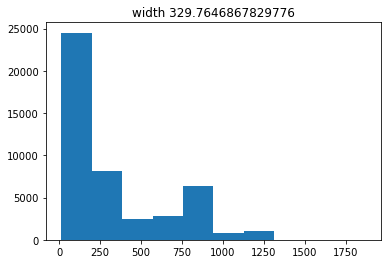

In [32]:
plt.title('width '+ str(np.mean(object_width_list)))
ax = plt.hist(object_width_list)

In [ ]:
def load_pig():
    input_list = []
    bbox_list = []
    path_list = []
    for key in annotation:
        cls_bbox = annotation[key]
        cls_bbox = np.array(cls_bbox).reshape([-1, 5])
        cls = cls_bbox[:, 0:1]
        bbox = np.array(cls_bbox[:, 1:])

        path_image = key
        
        img = Image.open(path_image)    
        if use_size_down:
            w, h = img.size
            img = img.resize((w//2, h//2))

        scale = np.array((w, h, w, h))
        scale = np.reshape(scale, (1, 4))       
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        img_arr = np.array(img)    
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls = np.array(cls).reshape((-1, 1))
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(key)
        if len(input_list) % 200 == 0:        
            print(len(annotation), len(input_list), len(bbox_list))   
        if len(input_list) > max_data_m:
            break
        
    print(len(input_list), len(bbox_list))
    return input_list, bbox_list
    
input_list_pig, bbox_list_pig = load_pig()#1709, 1759

13164 200 200
13164 400 400
13164 600 600
13164 800 800
13164 1000 1000
13164 1200 1200
13164 1400 1400
13164 1600 1600
13164 1800 1800
13164 2000 2000
13164 2200 2200
13164 2400 2400
13164 2600 2600
13164 2800 2800
13164 3000 3000
13164 3200 3200
13164 3400 3400
13164 3600 3600


In [ ]:
np.array(class_names_kor)

In [ ]:
cbbox = np.concatenate(bbox_list_pig, 0)
print(cbbox.shape)
h = plt.hist(cbbox[:, 0], bins=len(class_names))

In [ ]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [ ]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [ ]:
def tile_object(X, BBOX, scope=0.5):
    
    crop_xs = []
    crop_bboxs = []
    for i in range(len(X)):
        x = X[i]
        img_h, img_w, img_c = x.shape
        bbox = BBOX[i]
        #print('len', len(x), len(bbox), x.shape, bbox.shape)
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        box_h = y1 - y0
        box_w = x1 - x0
        box_y_min = np.min(y0)
        box_x_min = np.min(x0)        
        box_y_max = np.max(y1)
        box_x_max = np.max(x1)        
        if box_y_max - box_y_min < scope and box_x_max - box_x_min < scope:
            
            cx = np.mean((box_x_min + box_x_max)/2)
            
            if cx < 0.5:
                tx0 = np.maximum(0, cx - scope/2)
                tx1 = tx0 + scope
            else:
                tx1 = np.minimum(1.0, cx + scope/2)
                tx0 = tx1 - scope
                        
            tbox = np.stack((cls, (x0 - tx0)/scope, y0, (x1 - tx0)/scope, y1), axis=1)            
            
            img_x0 = int(tx0 * img_w)
            img_x1 = img_x0 + int(img_w*scope)
            timg = x[:, img_x0:img_x1]
            
            img = Image.fromarray(timg)
            img_resized = img.resize((padded_image_shape[1]//2, padded_image_shape[0]))
            arr_resized = np.array(img_resized)            
            
            crop_xs.append(arr_resized)
            crop_bboxs.append(tbox)
    return crop_xs, crop_bboxs


In [ ]:
def attach_tiled_data(X, BBOX, row=2, col=2):
    m = len(X)
    attach_m = int(np.ceil(m/(row*col)))
    attach_xs = []
    attach_bboxs = []
    img_h, img_w, img_c = X[0].shape
    for i in range(attach_m):
        bg_color = np.median(X[i])
        attach_xs.append(bg_color + np.zeros((img_h*row, img_w*col, img_c)))    
        attach_bboxs.append([])
    
    m_rand = np.arange(m)
    np.random.shuffle(m_rand)
    for i in range(len(m_rand)):
        j = i#m_rand[i]
        x = X[j]
        bbox = BBOX[j]        
        img_h, img_w, img_c = x.shape
        ti = i//(row*col)
        ty = i%(row*col)//col
        tx = i%(row*col)%col
        dst_y0 = ty * img_h
        dst_y1 = dst_y0 + img_h
        dst_x0 = tx * img_w
        dst_x1 = dst_x0 + img_w
               
        attach_xs[ti][dst_y0:dst_y1, dst_x0:dst_x1] = x                    
        cls, x0, y0, x1, y1 = np.split(bbox, 5, -1)
        
        x_scale = 1.0 / col
        y_scale = 1.0 / row
        x0 = x0 * x_scale + tx * x_scale
        y0 = y0 * y_scale + ty * y_scale
        x1 = x1 * x_scale + tx * x_scale
        y1 = y1 * y_scale + ty * y_scale
        bbox = np.concatenate((cls, x0, y0, x1, y1), axis=1)        
        attach_bboxs[ti].extend(bbox)
            
    for i in range(len(attach_bboxs)):
        attach_bboxs[i] = np.stack(attach_bboxs[i], 0)
        
    return attach_xs, attach_bboxs

In [ ]:
def box_convert_cxy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate(( (y0+y1)/2, (x0+x1)/2 ), axis=1)

def box_swap_xy(box):
    y0, x0, y1, x1 = np.split(box, 4, axis=-1)    
    return np.concatenate((x0, y0, x1, y1), axis=1)

def box_convert_to_xywh(boxes):
    return np.concatenate(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)

def box_convert_to_corners(boxes):    
    return np.concatenate(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)

def angle_to_radian(angle):
    return angle * np.pi/180

def rotate_images(X, angle):
    rotate_X = []
    for i in range(len(X)):        
        x = X[i]
        img_h = x.shape[0]
        img_w = x.shape[1]
        img = Image.fromarray(x)                
        img_rotated = img.rotate(angle)
        rotate_X.append(np.array(img_rotated))

    return rotate_X    

In [ ]:
class_names_kor, class_names_kor.index('사람')

In [ ]:
def gen_rotate_data(X, BBOX, angle):
    rotate_xs = []
    rotate_bboxs = []
    m = len(X)
    for i in range(m):        
        x = X[i]
        
        bbox = BBOX[i]
        cls = bbox[:, 0]
        x0 = bbox[:, 1]
        y0 = bbox[:, 2]
        x1 = bbox[:, 3]
        y1 = bbox[:, 4]
        
        if class_names_kor.index('사람') in cls.astype(np.int):
            print('skip person contain image', i, cls)
            continue
        
        if class_names_kor.index('큰부리까마귀') + 0.1 >= np.max(cls):
            print('skip only 큰부리까마귀', i, cls)
            continue
        
        
        box = bbox[:, 1:]
        box_xywh = box_convert_to_xywh(box)
        box_xy = box_xywh[:, :2] 
        box_wh = box_xywh[:, 2:] 
        box_uv = (np.reshape(box_xy, [-1, 2]) - 0.5) * 2
        
        img_h, img_w, img_c = x.shape
        img = Image.fromarray(x)        
        scale_mat = np.array([1, 0, 0, 1.0*img_h/img_w]).reshape((2,2))
        scale_mat_rev = np.array([1, 0, 0, 1.0*img_w/img_h]).reshape((2,2))        
        
        radian = angle_to_radian(angle)        
        rotate_mat = np.array([np.cos(radian), -np.sin(radian), np.sin(radian), np.cos(radian)])        
        rotate_mat = np.reshape(rotate_mat, (2, 2))
        box_uv_trans = np.matmul(box_uv, scale_mat)
        box_uv_trans = np.matmul(box_uv_trans, rotate_mat)
        box_uv_trans = np.matmul(box_uv_trans, scale_mat_rev)
        box_trans = (box_uv_trans + 1)/2
        box_trans_xy = np.reshape(box_trans, [-1, 2])
        box_trans_xywh = np.concatenate((box_trans_xy, box_wh), axis=1)
        box_trans = box_convert_to_corners(box_trans_xywh)
   
        #if np.min(box_trans)<0 or np.max(box_trans)>1: continue
        
        bbox_trans = np.concatenate((np.expand_dims(cls, 1), box_trans), axis=1)
   
        img_rotated = img.rotate(angle)
        #plt.imshow(img_rotated)
        rotate_xs.append(np.array(img_rotated))
        rotate_bboxs.append(bbox_trans)

    return rotate_xs, rotate_bboxs        

In [ ]:
def augment_flip_horizontal(X, Y):
    X_ = []
    Y_ = []
    for i in range(len(Y)):
        x = X[i]
        y = Y[i]
        cls, x1, y1, x2, y2 = np.split(y, 5, -1)
        print(i, cls, x1, y1, x2, y2)
        X_.append(x[:,::-1])
        y_flip_h = np.concatenate([cls, 1-x2, y1, 1-x1, y2], -1)
        Y_.append(y_flip_h)
    
    return X_, Y_

In [ ]:
len(input_list), len(input_list_pig)

In [ ]:
m = len(input_list)
print('m', m)
input_list_test_valid = input_list_pig[1::2]
bbox_list_test_valid = bbox_list_pig[1::2]

input_list_test = input_list_test_valid[1::2]
bbox_list_test = bbox_list_test_valid[1::2]

input_list_train = input_list_pig[::2] + input_list_test_valid[::2]# + input_list
bbox_list_train = bbox_list_pig[::2] + bbox_list_test_valid[::2]# + bbox_list 

print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

In [ ]:
x_rotate, y_rotate = gen_rotate_data(input_list_train, bbox_list_train, 2.0)
x_rotate1, y_rotate1 = gen_rotate_data(input_list_train, bbox_list_train, -2.0)
x_rotate2, y_rotate2 = gen_rotate_data(input_list_train, bbox_list_train, 3.0)
x_rotate3, y_rotate3 = gen_rotate_data(input_list_train, bbox_list_train, -3.0)

#display_data(x_rotate, y_rotate, stride=1)
input_list_train.extend(x_rotate)
bbox_list_train.extend(y_rotate)
input_list_train.extend(x_rotate1)
bbox_list_train.extend(y_rotate1)

input_list_train.extend(x_rotate2)
bbox_list_train.extend(y_rotate2)
input_list_train.extend(x_rotate3)
bbox_list_train.extend(y_rotate3)

print(len(x_rotate))

X_flip, Y_flip = augment_flip_horizontal(input_list_train, bbox_list_train)
input_list_train.extend(X_flip)
bbox_list_train.extend(Y_flip)

In [ ]:
print('len', len(input_list_train), len(input_list_test))

In [ ]:
display_data(input_list_train, bbox_list_train, stride=1000)

In [ ]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

def compute_iou(boxes1, boxes2):#compute_iou(anchor_boxes, gt_boxes)
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [ ]:
level_end - level_start

In [ ]:

"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""
class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.level_start = level_start
        self.level_end = level_end
        
        if anchor_k==9:
            self.aspect_ratios = [0.5, 1.0, 2.0]        
            self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        else:
            self.aspect_ratios = [1.0]        
            self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(self.level_start, self.level_end)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 196.0, 256.0]]                        
        self._areas = self._areas[:level_end - level_start]
        
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - self.level_start]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - self.level_start], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return tf.concat(anchors, axis=0)
    
    def get_anchors_check(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(self.level_start, self.level_end)
        ]
        return anchors

In [ ]:
level_start, level_end

In [ ]:
anchor_check = AnchorBox()

In [ ]:
anchors = anchor_check.get_anchors_check(128,128)
for anchor in anchors:
    print(anchor.shape, anchor[-1])

In [ ]:
padded_image_shape, 128*8

In [ ]:
"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
   
    return image, boxes

def random_flip_vertical(image, boxes):
    is_flipped = tf.zeros_like(boxes[:, 0])
    if tf.random.uniform(()) > 10.5:
        image = tf.image.flip_up_down(image)        
        boxes = tf.stack([boxes[:, 0], 1 - boxes[:, 3], boxes[:, 2], 1 - boxes[:, 1]], axis=-1)
        is_flipped = tf.ones_like(is_flipped)
        
    return image, boxes, is_flipped

def resize_and_pad_image(
    image, mask_obj=None, min_side=padded_image_shape[0], max_side=11333.0, jitter=[128*4, 128*4+1], stride=128.0
):
   
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1]) 
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    if mask_obj!=None:
        return image, image_shape, ratio, mask_obj
    return image, image_shape, ratio

def resize_and_pad_image_bbox(#resize
    image, bbox, mask_obj=None, min_side=padded_image_shape[0], 
    max_side=1024.0*4, jitter=[128*3+32, 128*4-32], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    ratio_jitter = tf.random.uniform(tf.shape(image_shape), -32, 32, dtype=tf.float32)
    image_shape += ratio_jitter      
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    if mask_obj!=None:
        mask_obj = tf.image.resize(mask_obj, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
    if mask_obj!=None:
        mask_obj = tf.image.pad_to_bounding_box(mask_obj, 0, 0, padded_image_shape[0], padded_image_shape[1])        
    padded_image_shape = tf.cast(padded_image_shape, tf.float32)              
    pad_ratio = tf.cast(image_shape, tf.float32) / padded_image_shape
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    if mask_obj!=None:
        return image, padded_image_shape, ratio, bbox_padded, mask_obj    
    return image, padded_image_shape, ratio, bbox_padded


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    image, bbox, is_flipped = random_flip_vertical(image, bbox)    
    is_flipped = tf.cast(is_flipped, tf.int32)
    image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)
        
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


def preprocess_test_data(image, cls_bbox):         
    bbox = cls_bbox[:, 1:]
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)        
    
    image, image_shape, _ = resize_and_pad_image(image)
    is_flipped = tf.zeros_like(class_id)
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)    
    cls_flip = tf.stack((class_id, is_flipped), -1)
    return image, bbox, cls_flip


In [ ]:
def image_color_augment(x):
    if tf.random.uniform(()) < -0.5:
        x_max = tf.reduce_max(x, [1, 2], True)
        x = x_max - x    
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < -0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)        
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.pow(tf.reduce_mean(x), 0.3))
        x += noise
    if tf.random.uniform(()) < 0.2:
        x = gaussian_filter2d(x, filter_shape=tuple(np.random.randint(1, 10, (2))), sigma=10)
        #x = gaussian_filter2d(x, filter_shape=np.random.randint(3, 10, (2)), sigma=10)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=10)
        
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    
    return x

In [ ]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )    
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.25
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also need max iou cell
        
        positive_proposal_mask = tf.greater_equal(iou_matrix, match_iou)
        positive_mask = tf.reduce_any(positive_proposal_mask, axis=1)
        
        negative_mask = tf.less(max_iou, ignore_iou)
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True) 
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_anchor)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#new      
        
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))        
        
        return (
            matched_gt_idx,            
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(positive_max_mask, dtype=tf.float32),            
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, positive_max_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        matched_gt_boxes_size = tf.reduce_prod(matched_gt_boxes[:, 2:], 1)
        matched_gt_boxes_size = tf.sqrt(matched_gt_boxes_size)        
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)    
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), 0.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -1.0, cls_target)       
        cls_target = tf.expand_dims(cls_target, axis=-1)        
        positive_max_mask= tf.expand_dims(positive_max_mask, -1)
        label = tf.concat([box_target, cls_target, positive_max_mask], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, gt_boxes, cls_flip):
        """Creates box and classification targets for a batch"""
        #is_flipped 0 or 1
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        cls_ids, is_flipped = tf.split(cls_flip, 2, -1)
        cls_ids = tf.squeeze(cls_ids, -1)
        is_flipped = tf.squeeze(is_flipped, -1)
        is_flipped = tf.cast(is_flipped, tf.float32)
        
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        label = labels.stack()
        is_flipped_anchor = tf.zeros_like(label[:, :, :1]) + tf.reduce_max(is_flipped)
        label = tf.concat((label, is_flipped_anchor), -1)
        return batch_images, label      
    
    def encode_batch_train(self, batch_images, gt_boxes, cls):
        """Creates box and classification targets for a batch"""
        
        batch_images = image_color_augment(batch_images)#new        
        return self.encode_batch(batch_images, gt_boxes, cls)

In [ ]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

In [ ]:
def BifeaturePyramidNet(c345):
    regulizer  = tf.keras.regularizers.L2(l1)
    filters = 256    
    a2 = c345[0]
    a3 = c345[1]
    a4 = c345[2]
    a5 = c345[3]
    a6 = Conv2D(filters, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(a5)
    a7 = Conv2D(filters, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(a6)
    #a8 = Conv2D(filters, 3, 2, "same", activation=activation, kernel_regularizer=regulizer)(a7)
    
    #b3 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #b4 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a2_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a2)
    #a3_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_0 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    #a3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    #a4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    
    a33 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a3)
    a44 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a4)
    a55 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a5)
    a66 = Conv2D(filters*2, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(a6)
    a3_0, a3_1 = tf.split(a33, 2, -1)
    a4_0, a4_1 = tf.split(a44, 2, -1)
    a5_0, a5_1 = tf.split(a55, 2, -1)
    a6_0, a6_1 = tf.split(a66, 2, -1)
    
    a7_up = keras.layers.UpSampling2D(2)(a7)    
    b6 = keras.layers.Add()([a6_0, a7_up])  
    
    a6_up = keras.layers.UpSampling2D(2)(a6_0)    
    b5 = keras.layers.Add()([a5_0, a6_up])  
    
    a5_up = keras.layers.UpSampling2D(2)(a5_0)    
    b4 = keras.layers.Add()([a4_0, a5_up])  
    
    b4_up = keras.layers.UpSampling2D(2)(b4)
    b3 = keras.layers.Add()([a3_0, b4_up])  
    
    b3_up = keras.layers.UpSampling2D(2)(b3)
    b2 = keras.layers.Add()([a2_0, b3_up])
    
    b2_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b2)
    b3_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b3)    
    c3 = keras.layers.Add()([a3_1, b3_1, b2_down])
    
    c3_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c3)
    b4_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b4)    
    c4 = keras.layers.Add()([a4_1, b4_1, c3_down])
    
    c4_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c4)
    b5_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b5)    
    c5 = keras.layers.Add()([a5_1, b5_1, c4_down])    
    
    c5_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c5) 
    b6_1 = Conv2D(filters, 1, 1, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(b6)    
    c6 = keras.layers.Add()([a6, b6_1, c5_down]) 
    
    c6_down = Conv2D(filters, 3, 2, "same", groups=1, activation=activation, kernel_regularizer=regulizer)(c6)
    c7 = keras.layers.Add()([a7, c6_down]) 
    
    return c3, c4, c5, c6, c7

In [ ]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

inputs = Input(shape=(3, 3, 2))  # 18   
outputs = Conv2D(10, 3)(inputs)# 18 * 10 + 10 = 190
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

In [ ]:
#backbone = keras.applications.EfficientNetB3(include_top=False, input_shape=[128, 128, 3])
#backbone.summary()

inputs = Input(shape=(3, 3, 2))      # 9 + 9
outputs = Conv2D(10, 3, groups=2)(inputs) # 9*5 + 5 + 9*5 + 5
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


In [ ]:
def get_backbone():
    backbone = keras.applications.EfficientNetB2(include_top=False, input_shape=[None, None, 3])
    c2_output, c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['block2c_add', 'block3c_add', 'block5d_add', 'block6e_add']]
    #c4_output = (c4_output + c4a_output[:, :, :, :80])/2
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c2_output, c3_output, c4_output, c5_output]
    )
backbone = get_backbone()
#D0 for layer_name in ["block2b_add", "block3b_add", "block5c_add", "block6d_add"]]
#D2 ["block2c_add", "block3c_add", "block5d_add",'block6e_add']
#D3 ['block2c_add', 'block3c_add', 'block5e_add', 'top_activation']
#D4 ['block2d_add', 'block3d_add', 'block5f_add', 'top_activation']
#D7 for layer_name in ["block2f_add", "block3g_add", "block5j_add", "block6d_add"]]
#input                           (None, 64, 64, 3)   
#block2b_add (Add)               (None, 16, 16, 24) 
#block3b_add (Add)               (None, 8, 8, 40)    
#block4c_add (Add)               (None, 4, 4, 80)
#block5c_add (Add)               (None, 4, 4, 112) 
#block6d_add (Add)               (None, 2, 2, 192)

In [ ]:
backbone.trainable = True #finetune

In [ ]:
backbone.summary()

def get_backbone():
    backbone = keras.applications.MobileNetV2(include_top=False, input_shape=[None, None, 3])
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["block_6_expand_relu", "block_13_expand_relu", "out_relu"]]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )
backbone = get_backbone()

In [ ]:
level_start, level_end

In [ ]:
def createRetinaNet(num_classes, anchor_k, is_train=False):
    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
    inputs = Input(shape=(None, None, 3))        
    
    nets_3 = backbone(inputs, training=is_train)    
    #nets_3 = create_resnet_backbone(inputs / 255)            
    features = BifeaturePyramidNet(nets_3)    
    
    cls_outputs = []
    box_outputs = []
   
    kernel_init = tf.initializers.he_normal()
    regulizer = tf.keras.regularizers.L2(l1)
    #conv_c0 = keras.layers.Conv2D(256, 3, padding="same", activation=activation, kernel_initializer=kernel_init, kernel_regularizer=regulizer)    
    
    drop = keras.layers.Dropout(0.1)
    
    cbox_outputs = []
    N = tf.shape(inputs)[0]# TFLite cannot convert tf.shape() function
    #N = 1
        
    for i in range(0, len(features)):                    
        conv_0 = keras.layers.Conv2D(anchor_k * (4+num_classes), 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=prior_probability, name='head_conv_'+str(i))   
                
        cls_out = conv_0(drop(features[i]))
        cbox_out = tf.reshape(cls_out, [N, -1, 4+num_classes]) 
        cbox_outputs.append(cbox_out)
    
    outputs = tf.concat(cbox_outputs, axis=1)  
    
    model = keras.Model(inputs=inputs, outputs=outputs)#dual    
    
    return model


In [ ]:
def _decode_box_predictions(anchor_boxes, box_predictions):
    _box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    boxes = box_predictions * _box_variance
    boxes = tf.concat(
        [
            boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
            tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
        ],
        axis=-1,
    )
    boxes_transformed = convert_to_corners(boxes)
    return boxes_transformed

def decodePredictions(images, predictions, 
                      num_classes=num_classes,
                      confidence_threshold=0.5,
                      nms_iou_threshold=0.2,
                      max_detections_per_class=1000,
                      max_detections=1500,
                      box_variance=[0.1, 0.1, 0.2, 0.2]):
    
    _anchor_box = AnchorBox()
        
    image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
    #image_h = padded_image_shape[0]
    #image_w = padded_image_shape[1]
    anchor_boxes = _anchor_box.get_anchors(image_shape[1], image_shape[2])
    #anchor_boxes = _anchor_box.get_anchors(image_h, image_w)
    box_predictions = predictions[:, :, :4]
    objectness = tf.nn.sigmoid(predictions[:, :, 4:5])
    cls_score = predictions[:, :, 5:5+num_classes_real]
    cls_prob = tf.nn.softmax(cls_score)
    cls_prob_max = tf.reduce_max(cls_prob, -1)
   
    cls = tf.argmax(cls_score, -1)
    cls = tf.cast(cls, tf.float32)
    
    boxes = _decode_box_predictions(anchor_boxes[None, ...], box_predictions)
    boxes_2d = tf.reshape(boxes, [-1, 4])    
    scores = tf.reshape(objectness, [-1, 1])#new
    #scores = tf.sqrt(scores * tf.reshape(cls_prob_max, [-1, 1]))#new
    cls = tf.reshape(cls, [-1, 1])
    ccbox = tf.concat((cls, scores, boxes_2d), -1)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(    
        ccbox[:, 2:],
        ccbox[:, 1],        
        max_detections,
        nms_iou_threshold,
        confidence_threshold,        
    )
    output = tf.gather(ccbox, selected_indices)        
    return output   

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        loss = tf.where(loss < 0.01, 0.0, loss)#new marginal loss        
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma, num_classes):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma
        self._num_classes = num_classes

        
    def call(self, y_cls, y_pred):
        y_cls = tf.cast(y_cls, dtype=tf.int32)
        y_hot = tf.one_hot(y_cls, depth=self._num_classes, dtype=tf.float32,)
        is_exist_non_human_class = tf.reduce_any(y_cls > 1)
        y_positive = tf.cast(y_cls > 0+1, tf.float32)#0:bg, 1:unknown        
        cls_weight = (y_positive + tf.cast(y_cls > 1 + 2, tf.float32)) / 2
        dead_cls = tf.cast(tf.logical_and(y_cls > 1, y_cls < 4), tf.float32)
        obj_weight = 1.0 - 0.5 * dead_cls
        
        obj_score = tf.identity(y_pred[:, :, 0], name='obj_score')
        objectness = obj_score + tf.reduce_mean(y_pred[:, :, 1:]*0, axis=-1)
       
        pt = tf.nn.sigmoid(objectness)        
        pt = tf.clip_by_value(pt, 1e-7, 1.0 - 1e-7)
                
        loss_p = - (1.0 - self._alpha) * tf.pow(1.0 - pt, self._gamma) * y_positive * tf.math.log(pt)        
        loss_f = - self._alpha * tf.pow(pt, self._gamma) * (1 - y_positive) * tf.math.log(1 - pt)
        loss_obj = loss_p + loss_f
        
        cls_k = len(class_names_kor)
        y_hot = y_hot[:, :, :num_classes_real]
        cls_pt = tf.nn.softmax(y_pred[:, :, 1:1+num_classes_real])        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        loss_cls = tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)                
        loss = self._gamma * (obj_weight * loss_obj + 0.5 * cls_weight * loss_cls)
        return loss

    
class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):#alpha=0.25
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma, num_classes-1)
        self._box_loss = RetinaNetBoxLoss(delta)        
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # y_pred : tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        
        box_labels = y_true[:, :, :4]
        y_cls = y_true[:, :, 4]
        positive_max_mask = y_true[:, :, 5] > 0#new
        
        box_predictions = y_pred[:, :, :4]
        h_obj = tf.nn.sigmoid(y_pred[:, :, 4])        
        cls_predictions = y_pred[:, :, 4:-1]   
    
        positive_mask = tf.greater(y_cls, 0.0)
        ignore_mask = tf.less(y_cls, 0.0)
        
        clf_loss = self._clf_loss(y_cls, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions) 
                                
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)        
        box_loss = tf.where(positive_mask, box_loss, 0.0)        
        
        max_alpha = 0.1
        clf_loss = tf.where(positive_max_mask, (1 + max_alpha) * clf_loss, (1 - max_alpha) * clf_loss)        
        box_loss = tf.where(positive_max_mask, (1 + max_alpha) * box_loss, (1 - max_alpha) * box_loss)
        #box_loss = tf.where(tf.logical_and(h_obj > 0.5, positive_max_mask), box_loss, 0.0)#new    
        
        positive_mask = tf.cast(positive_mask, tf.float32)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)                
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = (1 + max_alpha) * clf_loss + box_loss
        return loss 

In [ ]:
def tp(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)        
    return tp

def tn(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    true_negative = tf.cast(tf.logical_and(y_cls > 0, h_postive < 1), tf.float32)
    false_positive = (1 - y_positive) * h_postive
    false_negative = y_positive * (1 - h_postive)
                
    tn = tf.reduce_sum(true_negative, axis=1)    
    tn = tf.cast(tn, tf.float32)    
    return tn

def fp(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    false_positive = tf.cast(tf.logical_and(y_cls == 0, h_postive > 0), tf.float32)        
                    
    fp = tf.reduce_sum(false_positive, axis=1)    
    fp = tf.cast(fp, tf.float32)    
    return fp

def fn(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)        
    return fn

def recall(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = tf.cast(y_cls > 0, tf.int32)
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]
    h_prob = tf.nn.sigmoid(h_score)    
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    
    true_positives = tf.cast(tf.logical_and(y_cls > 0, h_postive>0), tf.float32)
    false_negative = y_positive * (1 - h_postive)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec

def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol != 0, tf.int32)
    h_obj_prob = tf.nn.sigmoid(y_pred[:, :, 4])
    h_cls_symbol = tf.round(h_obj_prob)    
    h_cls_symbol = tf.cast(h_cls_symbol, tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec

def accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_positive = y_cls > 0
    y_bg = tf.cast(tf.abs(y_cls)==0, tf.int32)
    h_score = y_pred[:, :, 4]        
    h_prob = tf.nn.sigmoid(h_score)
    h_postive = tf.cast(tf.round(h_prob), tf.int32)
    h_cls = tf.math.argmax(y_pred[:, :, 5:5+num_classes_real], -1, output_type=tf.int32)        
    acc = tf.boolean_mask(tf.equal(y_cls, h_cls), y_positive)    
    return acc

def flip_accuracy(y_true, y_pred):    
    y_cls = tf.cast(y_true[:, :, 4], tf.int32)
    y_flip = tf.cast(y_true[:, :, 6], tf.int32)
    y_positive = y_cls > 0
    h_prob = tf.nn.sigmoid(y_pred[:, :, -1])
    h_flip = tf.cast(tf.round(h_prob), tf.int32)    
    acc = tf.boolean_mask(tf.equal(y_flip, h_flip), y_positive)    
    #acc = tf.reduce_mean(tf.cast(acc, tf.float32))
    return acc

In [ ]:
label_encoder = LabelEncoder()
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)

In [ ]:
def generator():    
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]                
        yield (x, y_box)

def generator_test():    
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]        
        yield (x, y_box)

dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))

np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

In [ ]:
batch_size = 4 #finetune Freeze 32, 4 ok, 5 Warn
autotune = tf.data.experimental.AUTOTUNE

In [ ]:
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(32 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size)
train_dataset = train_dataset.map(label_encoder.encode_batch_train, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

In [ ]:
val_dataset = dataset_test.map(preprocess_test_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=False)
#val_dataset = val_dataset.padded_batch(batch_size=batch_size)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

In [ ]:
np.set_printoptions(precision=3, linewidth=200)
image_height, image_width = padded_image_shape

img_check = 0
for image, output_map in train_dataset:
    print('output_map', output_map.shape)
    cbbox = output_map    
    bbox = cbbox[:, :, :4]
    cls_gt = cbbox[:,:,4]
    img_m, image_height, image_width, image_ch = image.shape
    anchor_feature_size = [(np.ceil(image_height / 2 ** i), np.ceil(image_width / 2 ** i)) 
                           for i in range(level_start, level_end)]
    print('anchor_feature_size', anchor_feature_size)    
    m = len(cbbox)    
    positive_count = np.sum(cls_gt>0)
    print('cbbox', cbbox.shape)
    print('cls_sum',np.sum(cls_gt < 0.0), np.sum(cls_gt == 0.0), 
          np.sum(cls_gt == 1.0), np.sum(cls_gt > 1.0))
    print('cls_mean',np.mean(cls_gt < 0.0), np.mean(cls_gt == 0.0), 
          np.mean(cls_gt == 1.0), np.mean(cls_gt > 0.0))
    print('shape',image.shape, cbbox.shape,'unique', np.unique(cls_gt))
    print('anchor_feature_size', anchor_feature_size)
    offset = 0
    positive_maps = []
    for anchor_feature_size_1 in anchor_feature_size:        
        fm_h, fm_w = anchor_feature_size_1
        fm_h = int(fm_h)
        fm_w = int(fm_w)        
        fm_wh = int(fm_h * fm_w * anchor_k)
        cbbox_anchor = cbbox[:, offset:offset+fm_wh, 4]
        cbbox_anchor = np.reshape(cbbox_anchor, [m, fm_h, fm_w, anchor_k])
        coount_m1 = np.count_nonzero(cbbox_anchor==-1)
        coount_0 = np.count_nonzero(cbbox_anchor==0)
        coount_1 = np.count_nonzero(cbbox_anchor==1)
        coount_1_over = np.count_nonzero(cbbox_anchor>1)
        positive_ratio = np.mean(cbbox_anchor>0)
        positive_maps.append(cbbox_anchor>0)
        print('cbbox_anchor', cbbox_anchor.shape, coount_m1, coount_0, coount_1, coount_1_over, 'ratio', positive_ratio)
        sample_0_cbbox = cbbox_anchor[0]
        sample_0_cbbox_sum = np.max(sample_0_cbbox, -1).astype(np.int)       
      
        offset += fm_wh
        if False:            
            file_name = str(fm_h)+ '_' + str(fm_w)+ '.txt'
            np.savetxt(file_name,sample_0_cbbox_sum, fmt='%d',delimiter='')
    img_check = image
    break

In [ ]:
plt.imshow(np.max(positive_maps[0][0], -1))
plt.title(str(positive_maps[0].shape)+ str(np.mean(positive_maps[0][0]))+ ' ' + str(np.sum(positive_maps[0][0])))

In [ ]:
pmap0 = np.array(Image.fromarray(np.max(positive_maps[0][0],-1)).resize((image_width, image_height)))
pmap1 = np.array(Image.fromarray(np.max(positive_maps[1][0],-1)).resize((image_width, image_height)))
pmap2 = np.array(Image.fromarray(np.max(positive_maps[2][0],-1)).resize((image_width, image_height)))
pmap3 = np.array(Image.fromarray(np.max(positive_maps[3][0],-1)).resize((image_width, image_height)))
pmap4 = np.array(Image.fromarray(np.max(positive_maps[4][0],-1)).resize((image_width, image_height)))
pmap0 = pmap0.astype(np.uint8)
pmap1 = pmap1.astype(np.uint8)
pmap2 = pmap2.astype(np.uint8)
pmap3 = pmap3.astype(np.uint8)
pmap4 = pmap4.astype(np.uint8)

In [ ]:
pmap_with_img = np.array(img_check)[0]#*255
pmap_with_img = pmap_with_img.astype(np.uint8)
pmap_add = np.expand_dims(pmap0+pmap1+pmap2+pmap3+pmap4, -1)
pmap = (pmap_add>0).astype(np.uint8)*255
mix_rgb = np.concatenate((pmap, pmap_with_img[:,:,1:]),-1)
plt.figure(figsize=(14,14))
plt.imshow(mix_rgb)
plt.title(str(np.mean(pmap_add)))

In [ ]:
def load_weight():   
    weights_dir = path_weight#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [ ]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.1, clipvalue=5.)#warm up clipvalue=10. !
optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.1, clipvalue=10.)
loss_detect = RetinaNetLoss(num_classes)
model = createRetinaNet(num_classes, anchor_k)
#metrics = [recall, precision, accuracy]
metrics = [recall, precision, accuracy, tp, tn, fp, fn]
model.compile(loss=loss_detect, optimizer=optimizer, metrics=metrics)#[recall, precision, accuracy]
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=200
    )
]

In [ ]:
load_weight()

In [ ]:
print(len(input_list_train), len(input_list_test))

In [ ]:
'''
before   3s 32ms/step - loss: 5.6431 - recall: 0.8978 - precision: 0.9538 - accuracy: 0.4959 - tp: 43.4000 - tn: 4.3300 - fp: 10.4600 - fn: 4.3300
after  101s 31ms/step - loss: 0.9343 - recall: 0.9220 - precision: 0.9705 - accuracy: 0.9624 - tp: 81.0678 - tn: 5.3810 - fp: 8.1468 - fn: 5.3810
        97s 30ms/step - loss: 0.7515 - recall: 0.9336 - precision: 0.9723 - accuracy: 0.9813 - tp: 82.3051 - tn: 4.1437 - fp: 7.8271 - fn: 4.1437
'''
out = model.evaluate(val_dataset.take(10000))
#out = model.evaluate(train_dataset.take(1000))

In [ ]:
epochs = 10000
hist = model.fit(
    train_dataset,
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)
'''
effD2 Freeze:652ms/step - loss: 0.8893 - recall: 0.9685 - precision: 0.9854 - accuracy: 0.9676 - flip_accuracy: 0.9951
effD4 fine  : 1926s 340ms/step - loss: 4.3644 - recall: 0.4212 - precision: 0.7165 - accuracy: 0.3599 - tp: 56.8611
      fine  : 1879s 310ms/step - loss: 3.8263 - recall: 0.3655 - precision: 0.6898 - accuracy: 0.4074 - tp: 18.4866
      fine  :  395s 348ms/step - loss: 0.6502 - recall: 0.9364 - precision: 0.9775 - accuracy: 0.9709
               770s 468ms/step - loss: 0.8848 - recall: 0.9223 - precision: 0.9692 - accuracy: 0.9713 - tp: 78.4045 - tn: 5.4041 - fp: 7.2930 - fn: 5.4041
     rotate : 2875s 476ms/step - loss: 0.6503 - recall: 0.9334 - precision: 0.9748 - accuracy: 0.9814 - tp: 59.4221 - tn: 3.5259 - fp: 3.6282 - fn: 3.5259
'''

In [ ]:
model.save_weights(path_weight)
path_weight

In [ ]:
image = tf.keras.Input(shape=[padded_image_shape[0], padded_image_shape[1], 3], name="image")
predictions = model(image, training=False)

detections = decodePredictions(image, predictions, confidence_threshold=0.5, nms_iou_threshold=0.1)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    
    image = np.array(image, dtype=np.uint8)
    image = attach_crop_image(image, boxes, max_crop=200)        
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()        
   
    if boxes_gt is not None:
        for box in boxes_gt:        
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=2
            )
            ax.add_patch(patch)
            
    for box, cls, score in zip(boxes, classes, scores):        
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        color_text = edgecolors[cls]
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            
            cls_name = class_names[cls] if cls < len(class_names) else 'unknown'
            score_txt = str.format('%s %.2f' %(cls_name, score))
            ax.text(x1, y1+20, score_txt, bbox={"facecolor": color_text, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
          
    plt.show()
    return ax

In [ ]:
def check_test(test_datas, bboxs_label, step=1, is_show=True):
    list_h = []
    list_y = []
    i = 0
    for image, cbbox in test_datas: 
        if i%step==0:            
            bbox_annotation = bboxs_label[i]
            scale = np.array(image.shape[:2])[::-1]
            scale = np.reshape(scale, [1, 2])
            scale = np.concatenate((scale, scale), 1)
            gt_bbox = bbox_annotation[:, 1:] * scale
               
            input_image, _, ratio = resize_and_pad_image(image, jitter=None)
            input_image = tf.expand_dims(input_image, axis=0)
            #input_image = tf.cast(input_image, tf.uint8)
            detected_box = inference_model.predict(input_image)        
            print(input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio)
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)
            list_h.append(np.concatenate((np.expand_dims(cls_h,-1), box), -1))
            list_y.append(np.concatenate((bbox_annotation[:, :1], gt_bbox), -1))
            if is_show:
                visualize_detections(
                    image,
                    box,
                    cls_h,
                    scores,
                    boxes_gt=gt_bbox
                )
        i+=1
        
    return list_h, list_y

In [ ]:
list_h, list_y = check_test(dataset_test, bbox_list_test, step=1, is_show=False)

In [ ]:
check_test(dataset, bbox_list_train, step=1000)

performance

In [ ]:
len(class_names_kor), np.array(class_names_kor)

In [ ]:
def convert_xywh(box):#`[x, y, width, height] to corner
    
    xywh = np.concatenate([box[:2] - box[2:] / 2.0, box[:2] + box[2:] / 2.0], 0)
    xywh = np.reshape(xywh, (-1))
    return xywh
         
def iou(box1, box2):
   
    box1_corner = convert_xywh(box1)
    box2_corner = convert_xywh(box2)
        
    lu = np.maximum(box1_corner[:2], box2_corner[:2])
    rd = np.minimum(box1_corner[2:], box2_corner[2:])#todo update
    intersection = np.maximum(0.0, rd - lu)
    intersection_area = intersection[0] * intersection[1]
    boxes1_area = box1[2] * box1[3]
    boxes2_area = box2[2] * box2[3]
   
    union_area = np.maximum(
        boxes1_area + boxes2_area - intersection_area, 1e-8
    )    
    #print('intersection_area', intersection_area, union_area)
    v = np.clip(intersection_area / union_area, 0.0, 1.0)
    return v

In [ ]:
import copy

positives = np.zeros(len(class_names_kor), np.int)
trues = np.zeros_like(positives)
tp = np.zeros_like(positives)

_list_h = copy.deepcopy(list_h)
_list_y = copy.deepcopy(list_y)
for H, Y in zip(_list_h, _list_y):
         
    for h in H:
        h_cls = int(h[0])            
        trues[h_cls] += 1
        
    for y in Y:        
        
        y_cls = int(y[0])
        positives[y_cls] += 1
        
        for h in H:            
            h_cls = int(h[0]) 
            io = iou(y[1:], h[1:]) 
            if io > 0.5 and (h_cls == y_cls):
                #print('io', io)
                tp[y_cls] += 1
                y[0] = h[0] = -1
                #print('iou', io)
                break
        
print('positives', positives)
print('trues    ', trues)
print('tp       ', tp)
    

In [ ]:
print('positives', [p for p in positives])
print('trues    ', [p for p in trues])
print('tp       ', [p for p in tp])

In [ ]:
positives [   0   82 1318 2009    0    0 6358  522  310   48   11   12   13  372  309    1  172    0    0    0    0]
trues     [   0    0 1217 1854    0    0 6275  544  250   23    0   14    8  358  339    0  167    0    1    0    0]
tp        [   0    0 1170 1674    0    0 5854  366  164   11    0   11    8  343  286    0  139    0    0    0    0]

In [ ]:
class_names_kor

Freeze Model

In [ ]:
inference_model.save('./pig_efficientDet-D2_save')

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [ ]:
 # Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: inference_model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(inference_model.inputs[0].shape, inference_model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]


In [ ]:
print(type(frozen_func.outputs))
frozen_list = frozen_func.outputs
print(frozen_list)
print(len(frozen_list))

print(type(frozen_func.inputs))
frozen_list = frozen_func.inputs
print(frozen_list)
print(len(frozen_list))

In [ ]:
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="pig_EfficientDet-D2_frozen_graph.pb",
                  as_text=False)

In [ ]:
def check_error(X, Y, Path, step=1):
    
    for i in range(len(X)): 
        image = X[i]
        bbox_annotation = Y[i]
        path = Path[i]
        
        scale = np.array(image.shape[:2])[::-1]
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = bbox_annotation[:, 1:] * scale

        input_image, _, ratio = resize_and_pad_image(image, jitter=None)
        input_image = tf.expand_dims(input_image, axis=0)

        detected_box = inference_model.predict(input_image)
        detect_k = len(detected_box)
        if detect_k!= len(bbox_annotation):
            print(path, input_image.shape, 'detected_box', detected_box.shape, scale, 'ratio',ratio.numpy())
            #(1, 1024, 1920, 3) detected_box (7, 6) [[1920 1080 1920 1080]] ratio tf.Tensor(0.94814813, shape=(), dtype=float32)
            cls_h = detected_box[:, 0].astype(np.int)
            scores = detected_box[:, 1]
            box = detected_box[:, 2:] / ratio
            #print('box', box)

            visualize_detections(
                image,
                box,
                cls_h,
                scores,
                boxes_gt=gt_bbox
            )
        

In [ ]:
start = 0
end = start + 100
check_error(input_list[start:end], bbox_list[start:end], path_list[start:end])

## load model from .pb file

In [ ]:
saved_model_pb = './pig_pb'

In [ ]:
inference_model.save(saved_model_pb)

In [ ]:
custom_objects = {'recall':recall,'precision':precision}
model_loaded = keras.models.load_model(saved_model_pb, custom_objects=custom_objects, compile=False)
#model_loaded.summary()

In [ ]:
model_loaded.compile()

In [ ]:
for image, cbbox in val_dataset: 
    
    detected_box = model_loaded.predict(image)
    print('detected_box', detected_box.shape)
    if len(detected_box) > 0:
        cls_h = detected_box[:, 0].astype(np.int)
        scores = detected_box[:, 1]
        box = detected_box[:, 2:]

        visualize_detections(
            image[0],
            box,
            cls_h,
            scores
        )    
    break